In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# загружаем набор данных
train = pd.read_csv('Data/Normality.csv', sep=';')
# выводим первые 5 наблюдений
train.head()

,AGE,PERSONAL_INCOME,CREDIT,FST_PAYMENT,FACT_LIVING_TERM,LOAN_AVG_DLQ_AMT
0,41,20000.0,65000.0,10000.0,204.0,0.0
1,53,13000.0,16460.0,10000.0,252.0,0.0
2,23,9500.0,25000.0,12000.0,96.0,0.0
3,31,7000.0,2500.0,790.0,7.0,0.0
4,49,15000.0,9300.0,1112.0,22.0,0.0


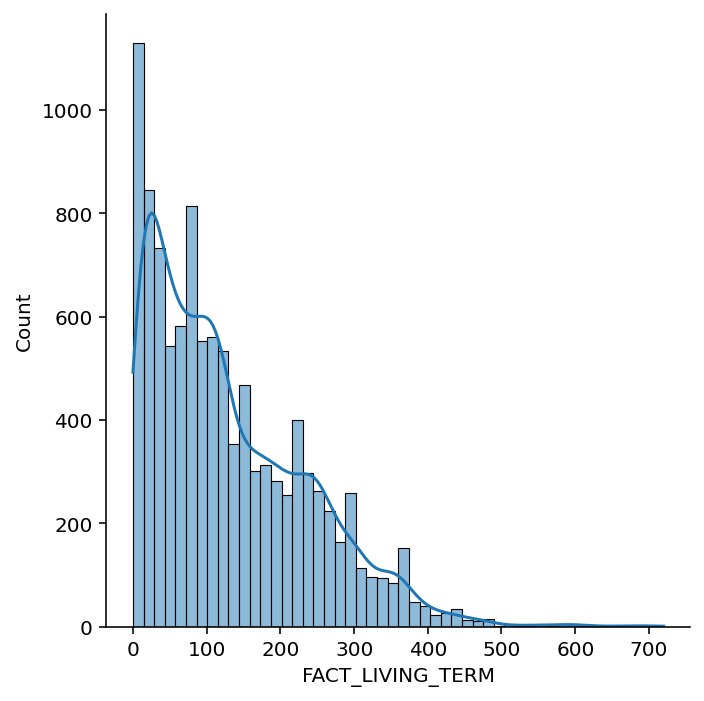

In [3]:
# строим гистограмму распределения
# для переменной FACT_LIVING_TERM
sns.displot(data=train, x='FACT_LIVING_TERM', kde=True);

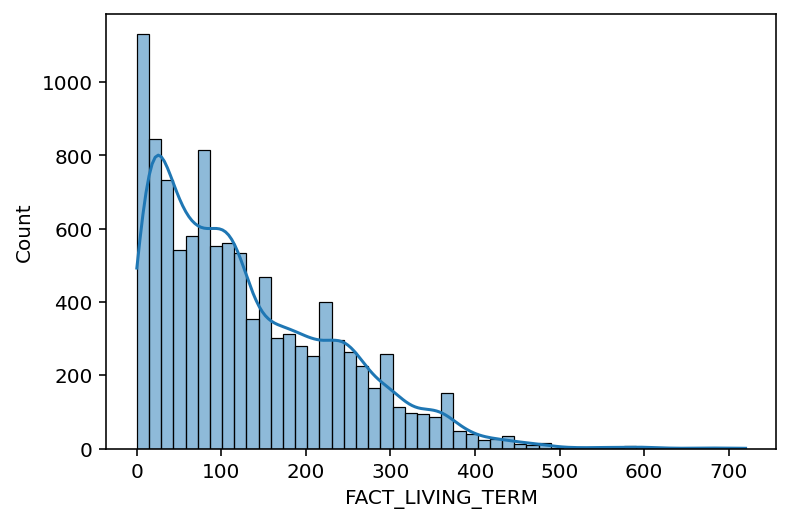

In [4]:
# строим гистограмму распределения
# для переменной FACT_LIVING_TERM
sns.histplot(data=train, x='FACT_LIVING_TERM', kde=True);

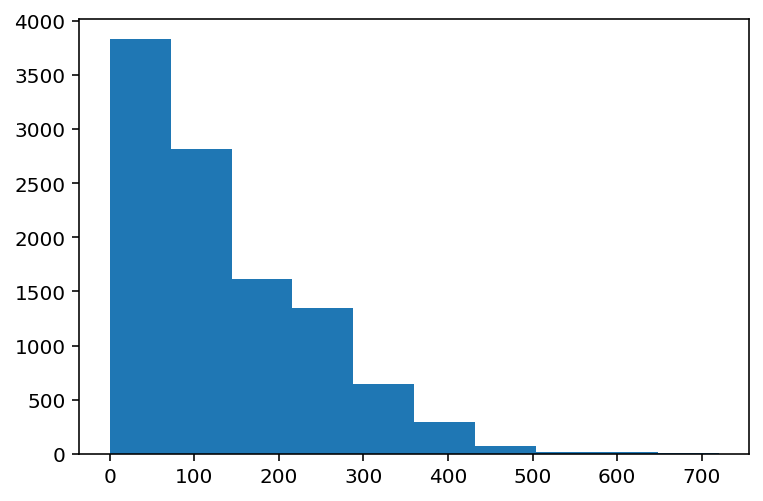

In [5]:
# строим гистограмму распределения
# для переменной FACT_LIVING_TERM
plt.hist(train['FACT_LIVING_TERM']);

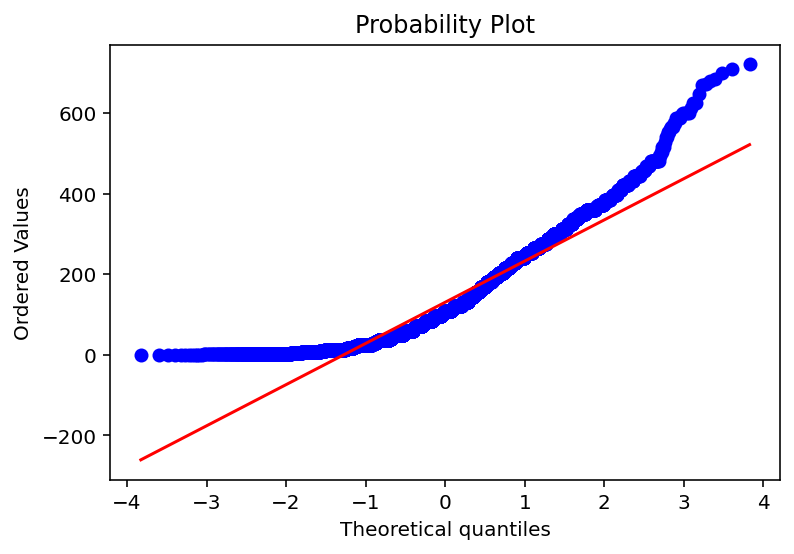

In [6]:
# строим график квантиль-квантиль 
# для переменной FACT_LIVING_TERM
fig = plt.figure()
res = stats.probplot(train['FACT_LIVING_TERM'], plot=plt)

In [7]:
# вычисляем скос и эксцесс
print("Скос", train['FACT_LIVING_TERM'].skew())
print("Эксцесс", train['FACT_LIVING_TERM'].kurtosis())

Скос 1.0181444392860792
Эксцесс 0.9035560079843634


In [8]:
# пишем функцию, вычисляющую скос
def skewness(var, df):
    num = np.mean(np.power(df[var] - df[var].mean(), 3))
    dem = np.power(df[var].std(), 3) 
    res = num / dem
    return res

In [9]:
# применяем функцию для вычисления скоса
skewness('FACT_LIVING_TERM', train)

1.0178578174556934

In [10]:
# пишем функцию, вычисляющую эксцесс
def excess_kurtosis(var, df):
    num = np.mean(np.power(df[var] - df[var].mean(), 4))
    dem = np.power(df[var].std(), 4) 
    res = (num / dem) - 3
    return res

In [11]:
# применяем функцию для вычисления эксцесса
excess_kurtosis('FACT_LIVING_TERM', train)

0.9018366578097732

In [12]:
# пишем функцию, которая вычисляет исходный скос и
# скос после выполненных преобразований
def diagnostics_skewness(df):
    # создаем списки
    col_list = df.select_dtypes(include=['number']).columns
    skew_initial_list = []
    skew_pos_reciprocal_list = []
    skew_neg_reciprocal_list = []
    skew_log_list = []
    skew_corr_log_001_list = []
    skew_corr_log_01_list = []
    skew_corr_log_1_list = []
    skew_corr_log_5_list = []
    skew_cbrt_list = []
    skew_sqrt_list = []
    
    # создаем копию датафрейма
    df_ = df.copy()
    # запускаем цикл, который вычисляет скос по каждой 
    # преобразованной переменной
    for i in col_list:
        df_[i] = df_[i].fillna(df_[i].median())
        skew_initial = df_[i].skew()
        skew_pos_reciprocal = (1 / (df_[i].clip(0.01))).skew()
        skew_neg_reciprocal = (-1 / (df_[i].clip(0.01))).skew()
        skew_log = np.log(df[i].clip(0.01)).skew()
        skew_corr_log_001 = np.log((df_[i].clip(0.01) / 
                                    df_[i].mean()) + 0.001).skew()
        skew_corr_log_01 = np.log((df_[i].clip(0.01) / 
                                   df_[i].mean()) + 0.01).skew()
        skew_corr_log_1 = np.log((df_[i].clip(0.01) / 
                                  df_[i].mean()) + 0.1).skew()
        skew_corr_log_5 = np.log((df_[i].clip(0.01) / 
                                  df_[i].mean()) + 0.5).skew()
        skew_cbrt = (np.sign(df_[i]) * np.cbrt(df_[i].abs())).skew()
        skew_sqrt = (np.sign(df_[i]) * np.sqrt(df_[i].abs())).skew() 
        skew_initial_list.append(skew_initial)
        skew_pos_reciprocal_list.append(skew_pos_reciprocal)
        skew_neg_reciprocal_list.append(skew_neg_reciprocal)
        skew_log_list.append(skew_log)
        skew_corr_log_001_list.append(skew_corr_log_001)
        skew_corr_log_01_list.append(skew_corr_log_01)
        skew_corr_log_1_list.append(skew_corr_log_1)
        skew_corr_log_5_list.append(skew_corr_log_5)
        skew_cbrt_list.append(skew_cbrt)
        skew_sqrt_list.append(skew_sqrt)   

    result = pd.DataFrame({'Переменная': col_list,
                           'Skew_init': skew_initial_list,
                           'Skew_pos_recip': skew_pos_reciprocal_list,
                           'Skew_neg_recip': skew_neg_reciprocal_list,
                           'Skew_log': skew_log_list,
                           'Skew_adj_log (k=0.001)': skew_corr_log_001_list,
                           'Skew_adj_log (k=0.01)': skew_corr_log_01_list,
                           'Skew_adj_log (k=0.1)': skew_corr_log_1_list,
                           'Skew_adj_log (k=0.5)': skew_corr_log_5_list,
                           'Skew_cbrt': skew_cbrt_list,
                           'Skew_sqrt': skew_sqrt_list})
    result = result.sort_values(by='Skew_init', ascending=False)
    result = np.round(result, 3)
    cm = sns.light_palette('magenta', as_cmap=True)
    return(result.style.background_gradient(cmap=cm))

In [13]:
# применяем нашу функцию
diagnostics_skewness(train)

,Переменная,Skew_init,Skew_pos_recip,Skew_neg_recip,Skew_log,Skew_adj_log (k=0.001),Skew_adj_log (k=0.01),Skew_adj_log (k=0.1),Skew_adj_log (k=0.5),Skew_cbrt,Skew_sqrt
3,FST_PAYMENT,6.744000,3.195000,-3.195000,-2.788000,-2.021000,-1.195000,0.046000,1.014000,0.186000,1.600000
5,LOAN_AVG_DLQ_AMT,5.856000,-2.270000,2.270000,2.288000,2.302000,2.325000,2.388000,2.511000,2.519000,2.857000
1,PERSONAL_INCOME,5.024000,101.043000,-101.043000,0.130000,0.164000,0.253000,0.437000,0.835000,0.941000,1.428000
2,CREDIT,2.836000,1.518000,-1.518000,0.067000,0.070000,0.091000,0.265000,0.701000,0.737000,1.152000
4,FACT_LIVING_TERM,1.018000,29.702000,-29.702000,-1.446000,-1.207000,-0.954000,-0.433000,0.063000,-0.223000,0.135000
0,AGE,0.247000,0.543000,-0.543000,-0.142000,-0.141000,-0.137000,-0.103000,-0.005000,-0.010000,0.055000


Скос 29.75263889372499
Эксцесс 883.3956108502981


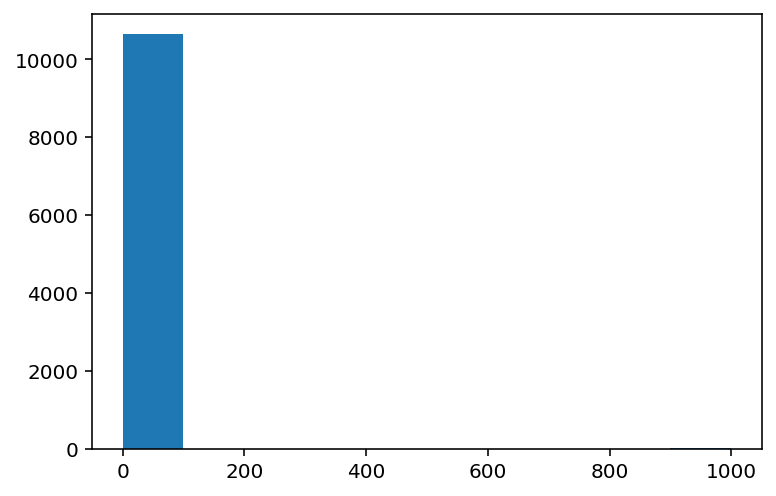

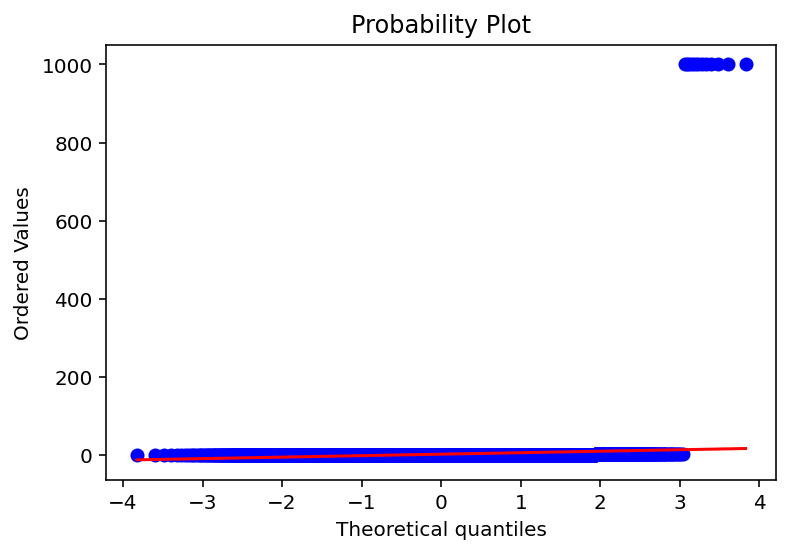

In [14]:
# вычисляем скос и эксцесс, гистограмму распределения
# и график квантиль-квантиль, применив обратное 
# преобразование для переменной FACT_LIVING_TERM,
# используем .clip(), чтобы не брать
# отрицательные числа и ноль
var = np.reciprocal(train['FACT_LIVING_TERM'].clip(0.001))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

Скос -1.7641384728316158
Эксцесс 7.61034596892353


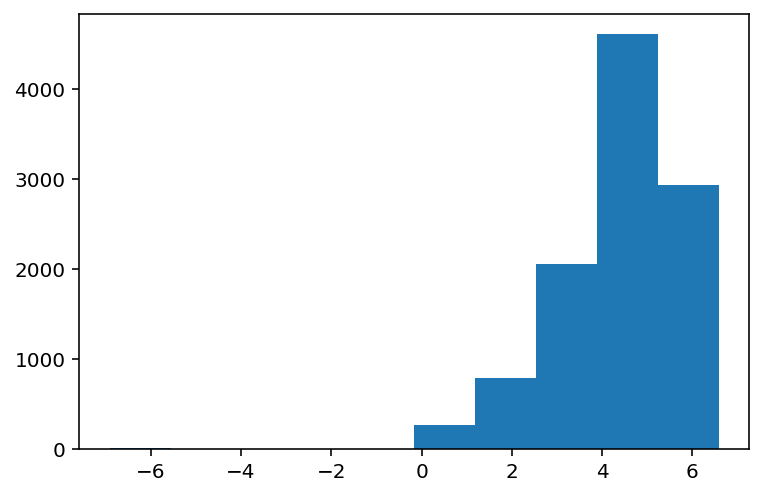

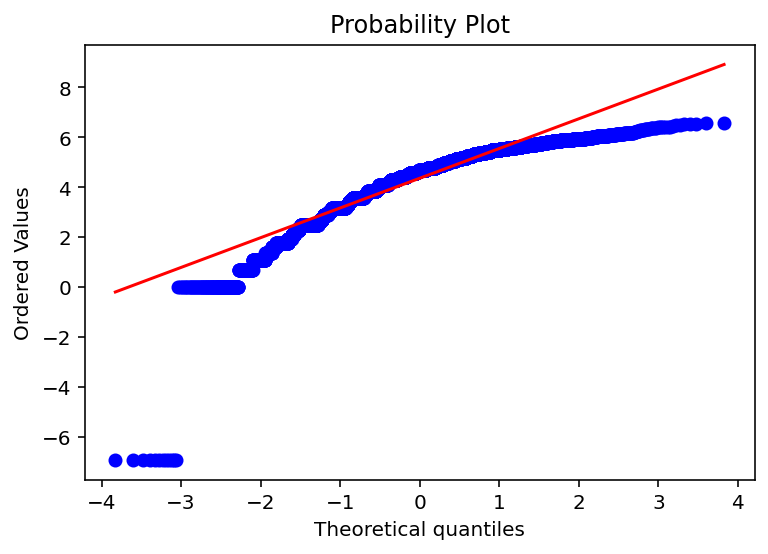

In [15]:
# вычисляем скос и эксцесс, гистограмму распределения
# и график квантиль-квантиль, применив логарифмическое
# преобразование для переменной FACT_LIVING_TERM,
# используем .clip(), чтобы не брать
# отрицательные числа и ноль
var = np.log(train['FACT_LIVING_TERM'].clip(0.001))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

Скос -1.210585215501142
Эксцесс 1.7521218621895827


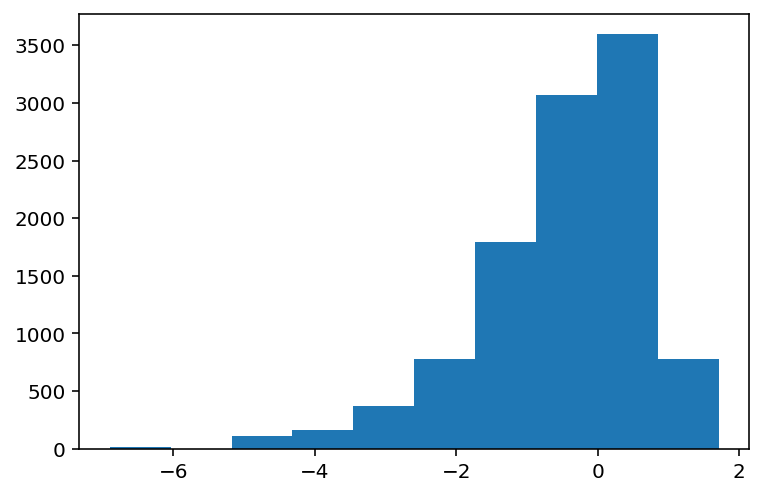

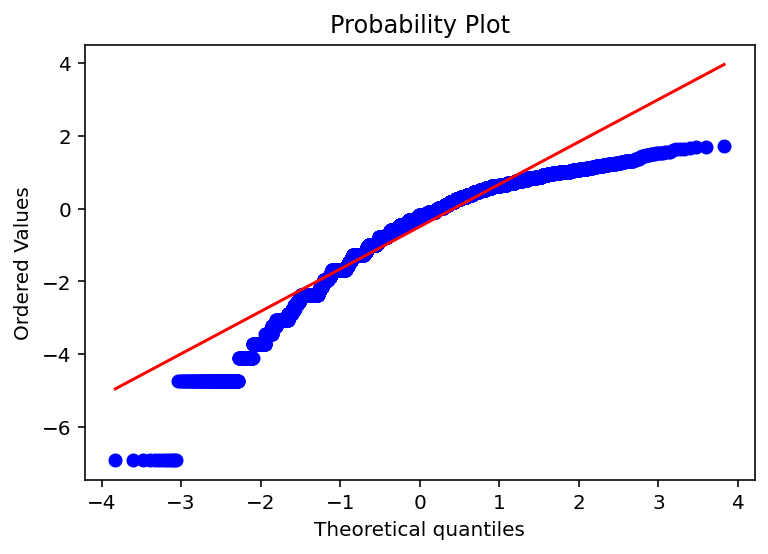

In [16]:
# вычисляем скос и эксцесс, гистограмму распределения
# и график квантиль-квантиль, применив логарифмическое
# преобразование по формуле log(x/mean(x)+k),
# где k - небольшое значение, близкое к 0,
# чтобы сильнее смещать распределение влево,
# используем .clip(), чтобы не брать
# отрицательные числа и ноль
k = 0.001
var = np.log((train['FACT_LIVING_TERM'].clip(0.001) / 
              train['FACT_LIVING_TERM'].mean()) + k)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

Скос 0.1212535167386184
Эксцесс -0.962190130053846


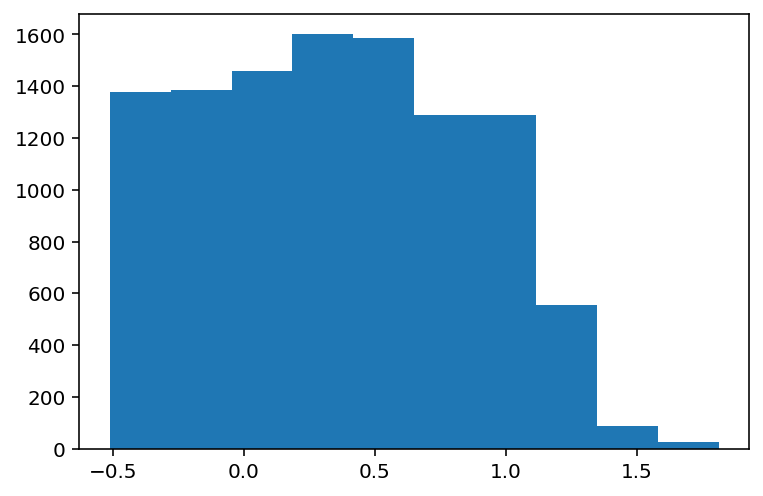

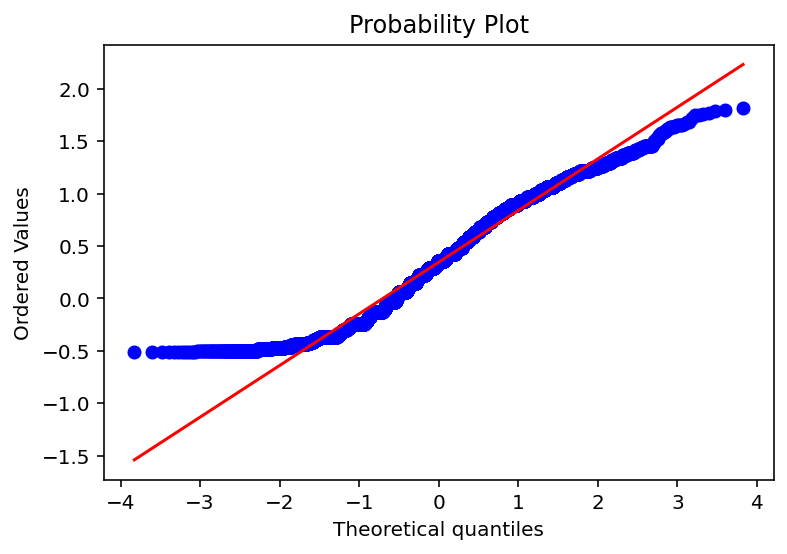

In [17]:
# вычисляем скос и эксцесс, гистограмму распределения
# и график квантиль-квантиль, применив логарифмическое
# преобразование по формуле log(x/mean(x)+k),
# где k - небольшое значение, близкое к 1,
# чтобы слабее смещать распределение влево,
# используем .clip(), чтобы не брать
# отрицательные числа и ноль
k = 0.6
var = np.log((train['FACT_LIVING_TERM'].clip(0.001) / 
              train['FACT_LIVING_TERM'].mean()) + k)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

Скос -0.4419381477873673
Эксцесс -0.30500979706137255


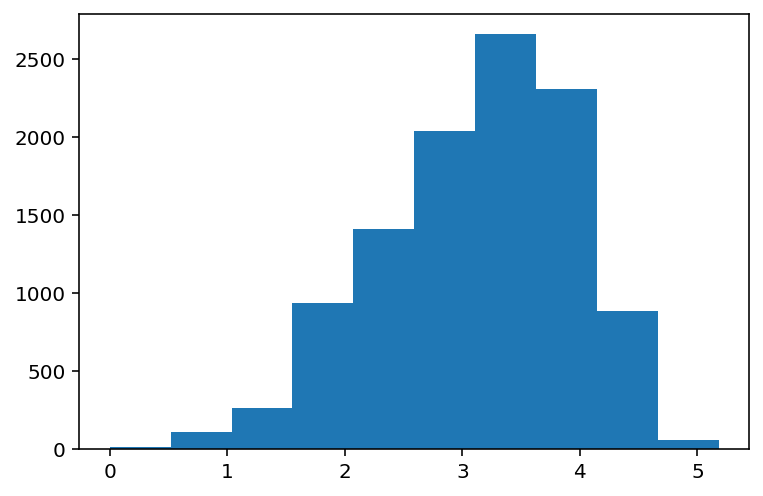

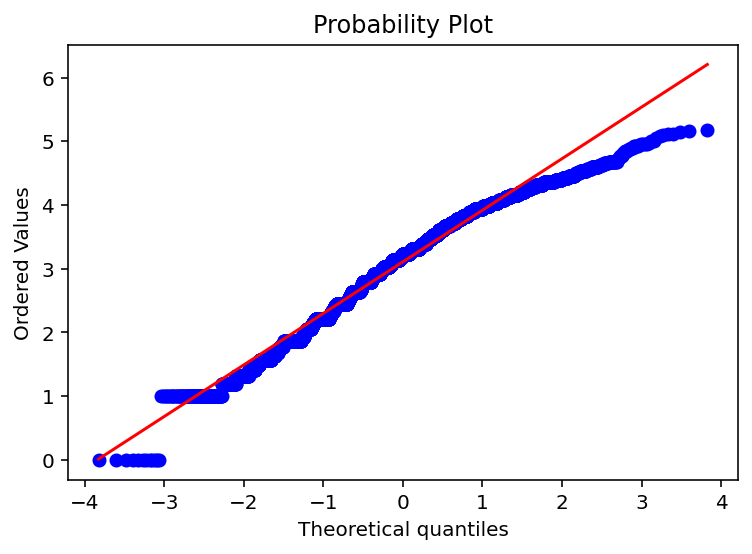

In [18]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# корнем четвертой степени, используем модуль, 
# чтобы не вычислять корни отрицательных чисел,
# и затем учитываем знак числа
var = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/4))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

Скос -0.222969034559257
Эксцесс -0.6070016622741847


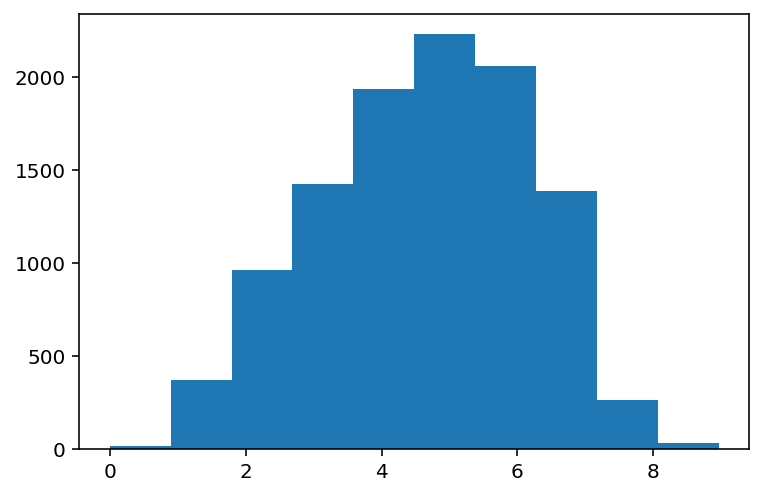

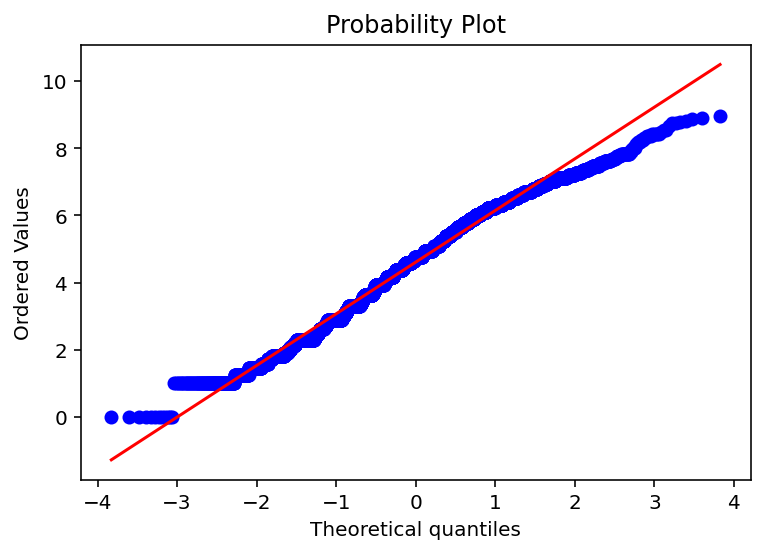

In [19]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# корнем третьей степени, используем модуль, 
# чтобы не вычислять корни отрицательных чисел,
# и затем учитываем знак числа
var = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/3))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

Скос 0.13476855245733127
Эксцесс -0.7037178210399051


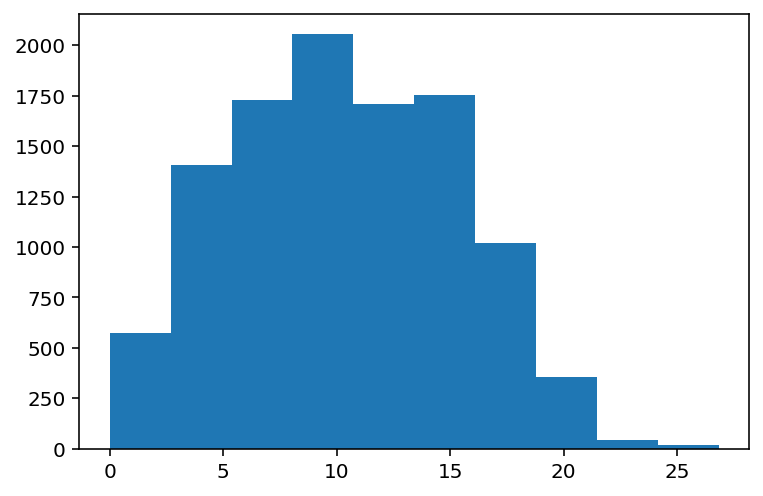

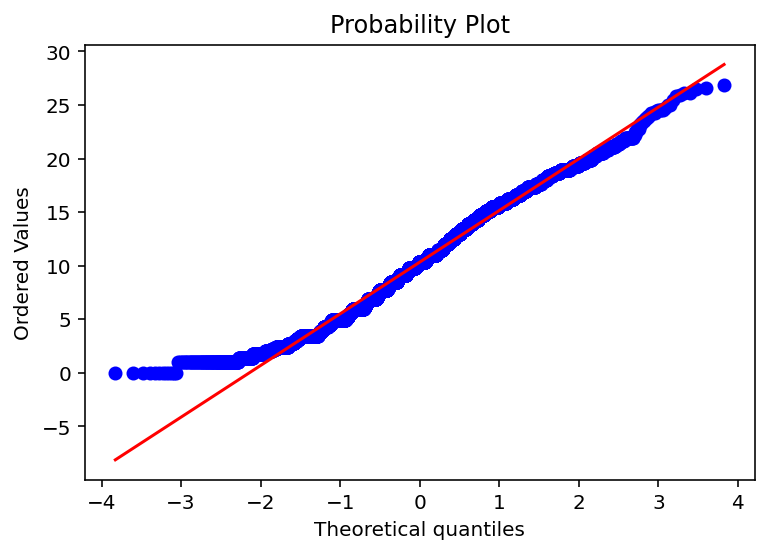

In [20]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# квадратным корнем, используем модуль, 
# чтобы не вычислять корни отрицательных чисел,
# и затем учитываем знак числа
var = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/2))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

In [21]:
# импортируем функцию boxcox
from scipy.stats import boxcox
# выполняем преобразование Бокса-Кокса
var, lam = boxcox(train['FACT_LIVING_TERM'].clip(0.001))
print("Lambda: %f" % lam)

Lambda: 0.374531


Скос -0.12681079843856088
Эксцесс -0.677976445569866


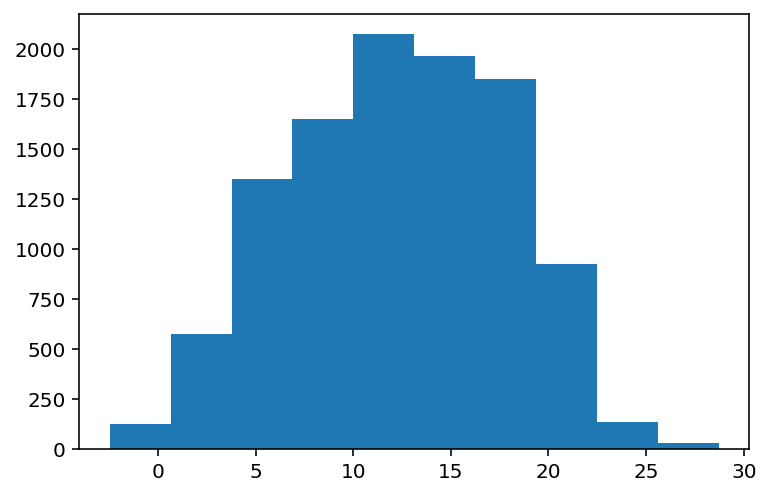

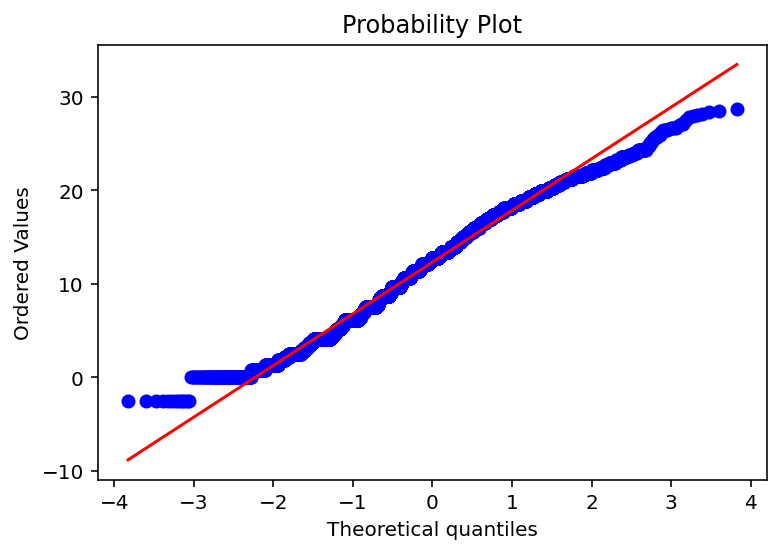

In [22]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# Бокса-Кокса
var = pd.Series(var)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())
plt.hist(var)
fig = plt.figure()
res = stats.probplot(var, plot=plt)

In [23]:
# создаем список количественных переменных
num_columns = ['PERSONAL_INCOME', 'AGE', 'CREDIT']

# смотрим минимальные значения
for c in num_columns:
    print(c, train[c].min())

PERSONAL_INCOME 24.0
AGE 21
CREDIT 2000.0


In [24]:
# импортируем класс PowerTransformer
from sklearn.preprocessing import PowerTransformer

# создаем экземпляр класса PowerTransformer
# и обучаем ее - вычисляем лямбды
power = PowerTransformer(
    method='box-cox', standardize=False).fit(train[num_columns])

In [25]:
# смотрим значения lambda
print(power.lambdas_)

[-0.04318489  0.28126877 -0.03649645]


In [26]:
# применяем преобразование Бокса-Кокса к переменным
# в обучающем массиве признаков
train[num_columns] = power.transform(train[num_columns])

In [27]:
# создаем список количественных переменных
num_columns2 = ['FST_PAYMENT', 'FACT_LIVING_TERM', 'LOAN_AVG_DLQ_AMT']

In [28]:
# смотрим минимальные значения
for c in num_columns2:
    print(c, train[c].min())

FST_PAYMENT 0.0
FACT_LIVING_TERM 0.0
LOAN_AVG_DLQ_AMT 0.0


In [29]:
# создаем экземпляр класса PowerTransformer
# и обучаем ее - вычисляем лямбды
power = PowerTransformer(
    method='box-cox', standardize=False).fit(train[num_columns2])

ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [30]:
# создаем модель экземпляр класса PowerTransformer
# и обучаем ее - вычисляем значения lambda
power = PowerTransformer(
    method='yeo-johnson', standardize=False).fit(train[num_columns2])
# применяем преобразование Йео-Джонсона к переменным
# в обучающем массиве признаков
train[num_columns2] = power.transform(train[num_columns2])